<a href="https://colab.research.google.com/github/SLVmain/Neural_Network_start/blob/Les_06/HW_06_part_1_birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Практическое задание

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-lp0pkpxa
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-lp0pkpxa
  Created wheel for tensorflow-examples: filename=tensorflow_examples-6a5c4df82b032e1ee1e5095e6f9baeb732b294db_-py3-none-any.whl size=268414 sha256=12c057765c164375949e2c7faefa784af57322f4bd2d291f38d5b3002e801f5e
  Stored in directory: /tmp/pip-ephem-wheel-cache-6xmx131b/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [2]:
try:
  %tensorflow_version only exists in Colab.
  #%tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

Unknown TensorFlow version: only exists in Colab.
Currently selected TF version: 2.x
Available versions:
 * 1.x
 * 2.x


In [3]:
import tensorflow.compat.v2 as tf

In [32]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K


import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

## Загрузка датасета caltech_birds2011

In [5]:
ds_names = ('caltech_birds2011',)
dataset_all, info = tfds.load(ds_names[0], split=['train', 'test'], with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2011/0.1.1.incompleteZ4MEKA/caltech_birds2011-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2011/0.1.1.incompleteZ4MEKA/caltech_birds2011-test.tfrecord
Dataset caltech_birds2011 downloaded and prepared to /root/tensorflow_datasets/caltech_birds2011/0.1.1. Subsequent calls will reuse this data.


In [6]:
info

tfds.core.DatasetInfo(
    name='caltech_birds2011',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=11788,
    splits={
        'test': 5794,
        'train': 5994,
    },
    supervised_keys=('im

Следующий код выполнит простую аугументацию данных посредством переворота изображений. В дополнение изображение будет нормализовано к 0 и 1. 

In [ ]:
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

In [7]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #input_mask -= 1
  input_mask = tf.cast(input_mask, tf.float32) / 200.0
  return input_image, input_mask

In [8]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [9]:
@tf.function
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Датасет уже содержит необходимые тестовый и тренировочный сплиты, поэтому давайте использовать их.

In [10]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // 10 // BATCH_SIZE

In [11]:
train = dataset_all[0].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset_all[1].map(load_image_test)

In [12]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
train_dataset.element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

Давайте посмотрим на пример  изображения из датасета и соотвествующую ему маску из датасета.

In [13]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

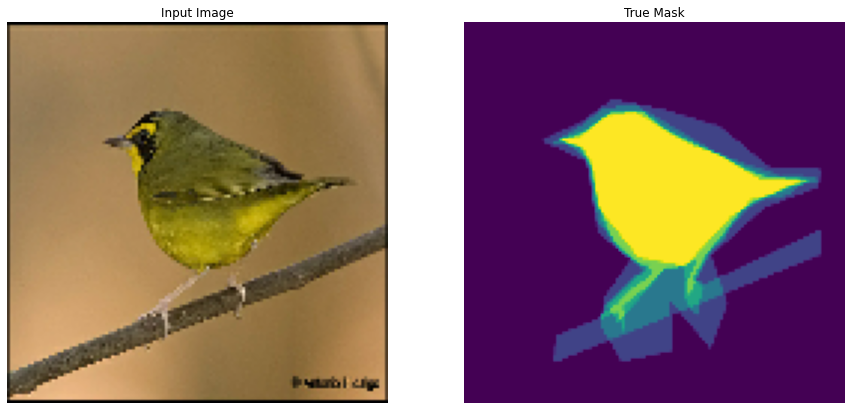

In [14]:
for image, mask in test_dataset.take(1):
  sample_image, sample_mask = image, mask
display([sample_image[0,:,:,:], sample_mask[0,:,:,:]])

In [ ]:
sample_mask.numpy().min(),sample_mask.numpy().max()

(0.0, 1.0)

In [ ]:
sample_mask.dtype

tf.float32

## Определение модели

Будем использовать модифицированный U-Net. В качестве энкодера будет использоваться предтренированный MobileNetV2.
Декодером будет апсемпл блок уже имплементированный в TensorFlow examples [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py).

Причина по который будет испольваться три канала заключается в том что у нас 3 возможных лейбла на каждый пиксель. Можно это воспринимать как классиификацию где кажедый пиксель будет принадлежать одному из трех классов.

In [15]:
OUTPUT_CHANNELS = 3

Как упоминалось ранее энкодером будет предтренированный MobileNetV2, который подготовлен и готов к использованию - [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). Энкодер состоит из определенных аутпутов из средних слоев модели. Обратите внимание энкодр не будет участвовать в процессе тренировкие модели.

In [16]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step




Декодер/апсемплер это просто серия апсемпл блоков имплементированнхы в TensorFlow examples.

In [17]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [18]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Тренировка модели
Now, all that is left to do is to compile and train the model. The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for 
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

Теперь, все что осталось это скомпилировать модель и начать процесс ее тренировки. Loss-функция, которую будем использовать - `losses.SparseCategoricalCrossentropy(from_logits=True)`. Причина использования данной loss-функции заключается в том, что нейросеть пытается назначить каждому пикселю лейбл, также как в задачах предсказания класса. Для модели в которой 3 каннала каждый из которых пытается предсказать класс `losses.SparseCategoricalCrossentropy(from_logits=True)` обычно также рекомендуется.
На выходе нейросети каждому пикселю назначается лейбл с наибольшим значением. Это то, что делает функция create_mask.


In [19]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Посмотрим на получившуюся архитектуру модели.

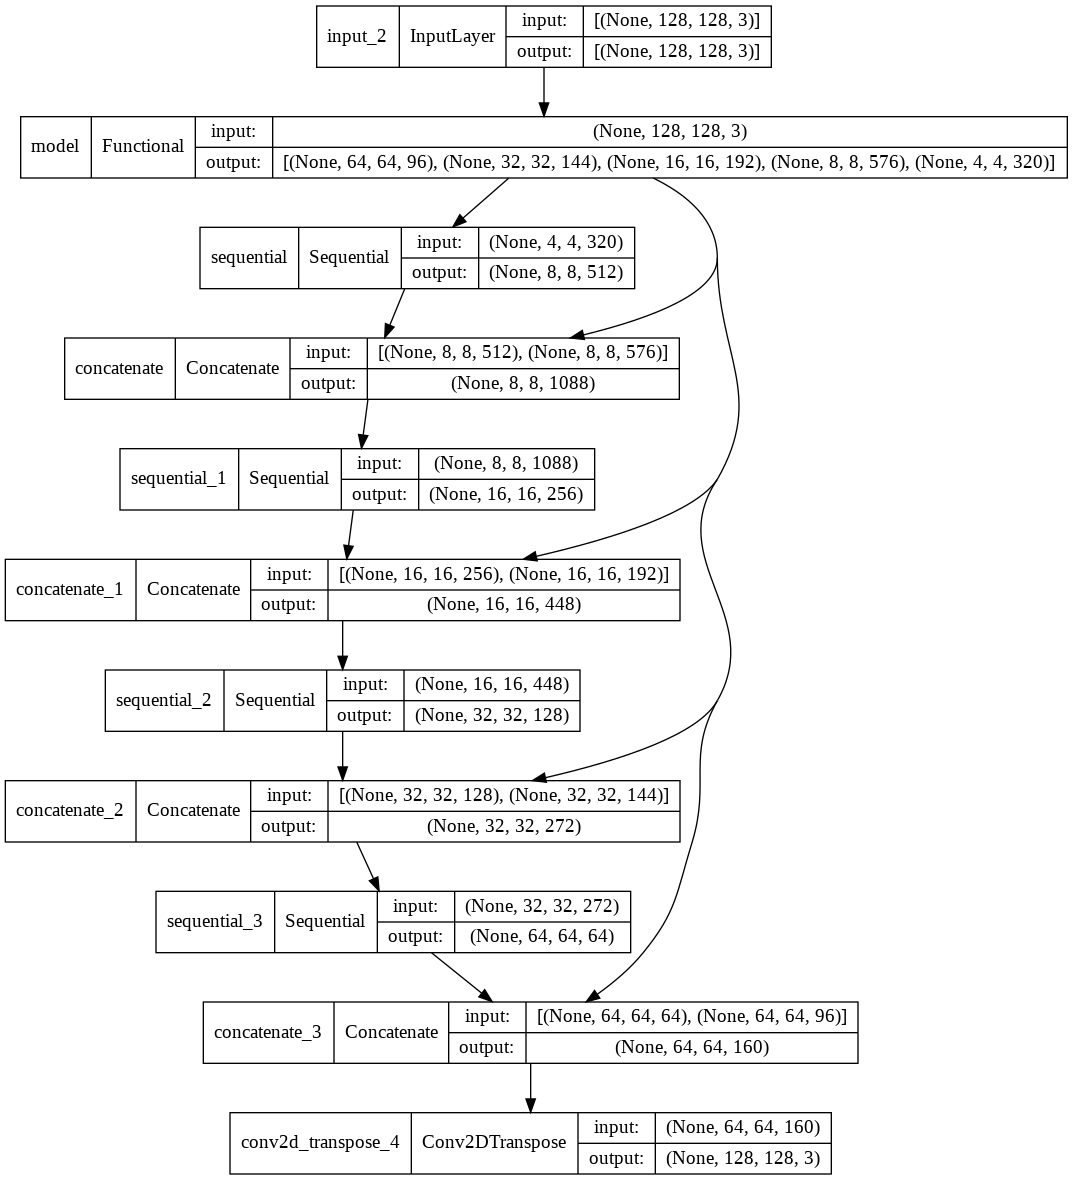

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)


Давайте попробуем сделать предсказание с помощью нашей модели до того как началось обучение.

In [21]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [22]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(1)
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image[0,:,:,:], sample_mask[0,:,:,:],
             create_mask(model.predict(sample_image[:,:,:]))])

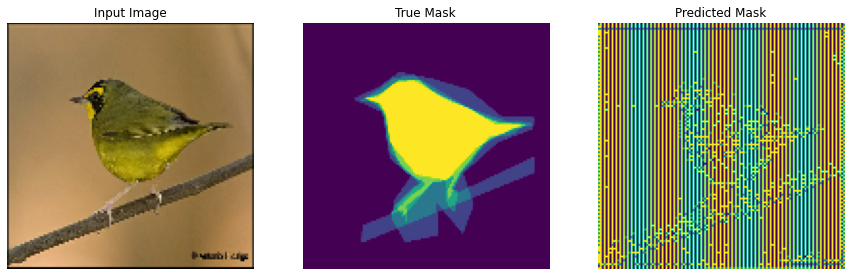

In [23]:
show_predictions()



Давайте осуществлять мониторинг того как улучшается работа модели в процессе обучения. Для завершения этой задачи callback функция определена ниже.

In [24]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

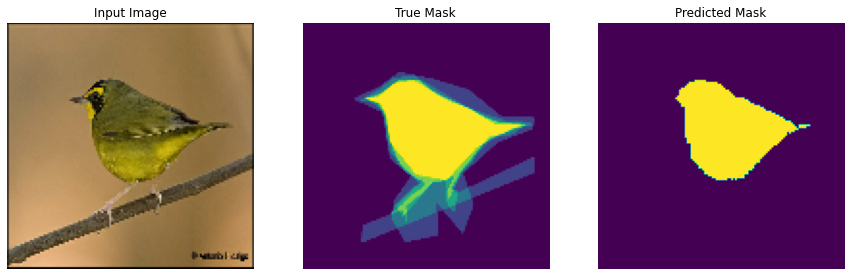


Sample Prediction after epoch 25

37/37 [==============================] - 23s 634ms/step - loss: 0.0666 - accuracy: 0.8298 - val_loss: 0.0667 - val_accuracy: 0.8388


In [25]:
EPOCHS = 25 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//10//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

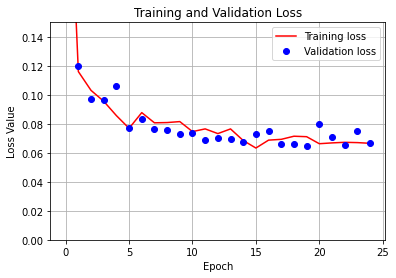

In [26]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.150])
plt.grid('on')
plt.legend()
plt.show()

## Make predictions

1


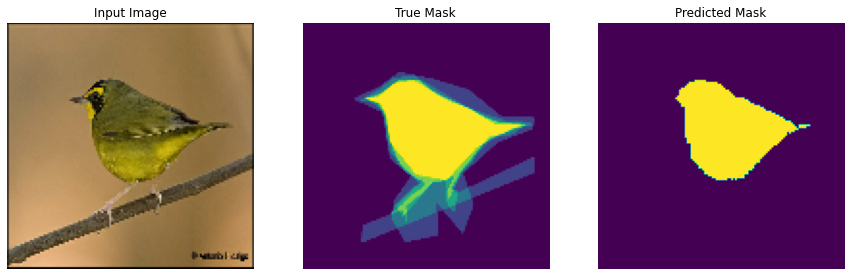

1


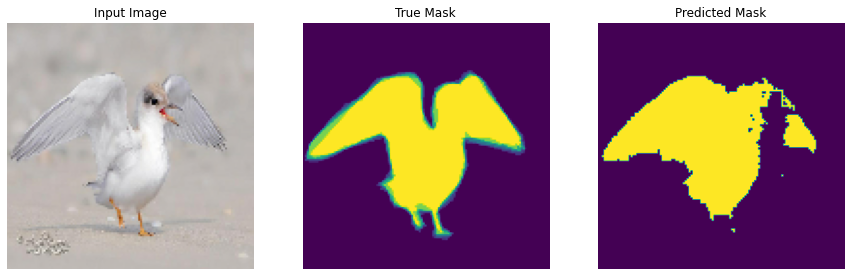

1


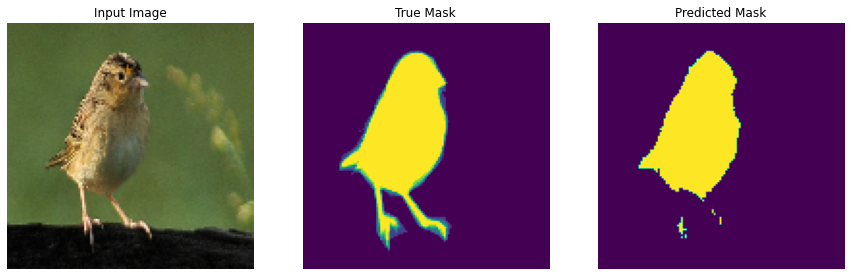

In [27]:
show_predictions(test_dataset, 3)

попробуем использовать метрику dice

In [34]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


In [35]:
model_d = unet_model(OUTPUT_CHANNELS)
model_d.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[dice_coef])

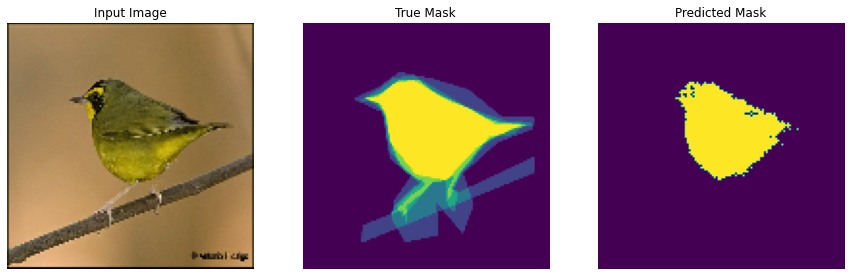


Sample Prediction after epoch 25

37/37 [==============================] - 29s 790ms/step - loss: 0.0532 - dice_coef: 0.3463 - val_loss: 0.0747 - val_dice_coef: 0.3178


In [36]:
EPOCHS = 25 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//10//BATCH_SIZE//VAL_SUBSPLITS

model_history = model_d.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

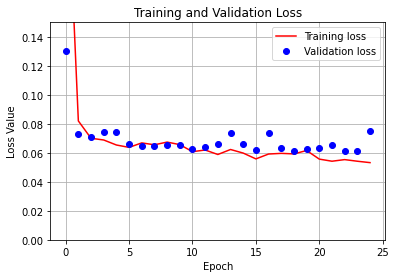

In [37]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.150])
plt.grid('on')
plt.legend()
plt.show()

## Make predictions

In [38]:
def show_predictions_d(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(1)
      pred_mask = model_d.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image[0,:,:,:], sample_mask[0,:,:,:],
             create_mask(model.predict(sample_image[:,:,:]))])

1


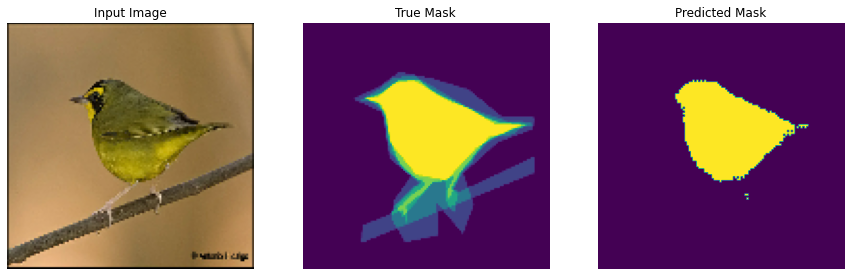

1


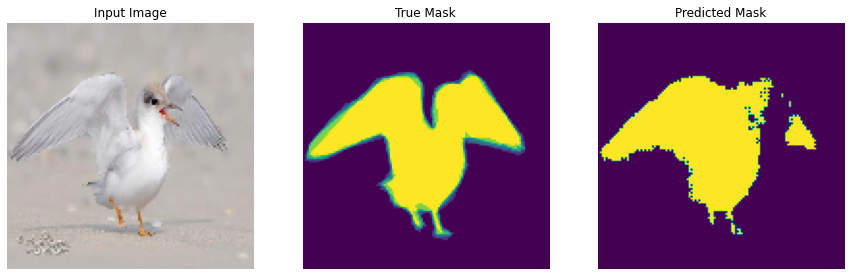

1


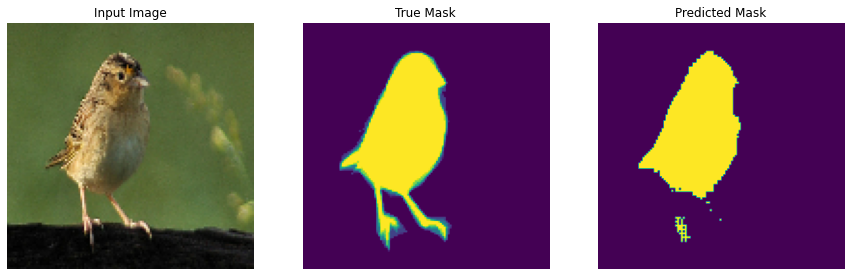

In [39]:
show_predictions_d(test_dataset, 3)

при использвания метрик accuracy и dice после 25 эпох обучения отличия незначительные